In [1]:
# import libraries 
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models  # Import models from TensorFlow

In [2]:
data = pd.read_csv('/Users/zaravanthoff/Desktop/MasterProject/Datasets/PublicDataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt', sep='\s+',header=None)
# Rename the columns
data.columns = ['Image', 'Class', 'Label', 'Xmin', 'Ymin', 'Xmax', 'Ymax']

folder_path = "/Users/zaravanthoff/Desktop/MasterProject/Datasets/PublicDataset/flickr_logos_27_dataset/flickr_logos_27_dataset_images"


In [3]:
data

,Image,Class,Label,Xmin,Ymin,Xmax,Ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


Here's a quick overview:

- Image: File name or path of the image.
- Class: The class of the object (e.g., Adidas, Yahoo).
- Label: The label or class ID of the object.
- Xmin, Ymin, Xmax, Ymax: The coordinates of the bounding box around the object in the image.

``Preprocessing data``

In [4]:
import cv2
import os
import pandas as pd
import numpy as np

def preprocess_data(data, folder_path, target_width=416, target_height=416):
    """
    Preprocesses images and labels from the given DataFrame.
    
    Args:
        data (DataFrame): DataFrame containing image filenames, labels, and bounding box coordinates.
        folder_path (str): Path to the folder containing the images.
        target_width (int): Target width for resizing the images.
        target_height (int): Target height for resizing the images.
    
    Returns:
        tuple: Tuple containing preprocessed images, labels, and adjusted bounding box coordinates.
    """
    resized_images = []
    labels = []
    adjusted_bboxes = []  # List to store adjusted bounding box coordinates

    # Iterate through each row in the dataset
    for index, row in data.iterrows():
        # Extract image filename from the dataset
        image_filename = row['Image']  # Accessing by column name
        
        # Construct the full path to the image
        image_path = os.path.join(folder_path, image_filename)
        
        try:
            # Read the image using OpenCV
            image = cv2.imread(image_path)
            
            # Check if the image was read successfully
            if image is None:
                raise FileNotFoundError(f"Unable to read image at path: {image_path}")
            
            # Resize the image to the target size
            resized_image = cv2.resize(image, (target_width, target_height))
            
            # Append resized image to the list
            resized_images.append(resized_image)
            
            # Append label to the list (assuming label is in the 'Class' column of the dataframe)
            label = row['Label']
            labels.append(label)
            
            # Adjust bounding box coordinates
            xmin = int(row['Xmin'] * (target_width / image.shape[1]))
            ymin = int(row['Ymin'] * (target_height / image.shape[0]))
            xmax = int(row['Xmax'] * (target_width / image.shape[1]))
            ymax = int(row['Ymax'] * (target_height / image.shape[0]))
            adjusted_bboxes.append((xmin, ymin, xmax, ymax))
            
            print(f"Image processed successfully: {image_filename}")
        except Exception as e:
            print(f"Error processing image at path {image_path}: {str(e)}")

    return np.array(resized_images), np.array(labels), np.array(adjusted_bboxes)

# def preprocess_labels(data):
#     """
#     Preprocesses labels by converting them to one-hot encoding.
    
#     Args:
#         data (DataFrame): DataFrame containing labels.
    
#     Returns:
#         DataFrame: DataFrame with one-hot encoded labels.
#     """
#     # Convert labels to one-hot encoding
#     labels = pd.get_dummies(data['Class'])
#     # Concatenate one-hot encoded labels with original DataFrame
#     data = pd.concat([data, labels], axis=1)
#     return data

In [5]:
# data = preprocess_labels(data)

# Preprocess images and labels
resized_images, labels, adjusted_bboxes = preprocess_data(data, folder_path)

Image processed successfully: 144503924.jpg
Image processed successfully: 2451569770.jpg
Image processed successfully: 390321909.jpg
Image processed successfully: 4761260517.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 1230939811.jpg
Image processed successfully: 1230939811.jpg
Image processed successfully: 2550056374.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image proces

In [6]:
def compute_bbox_deltas(data, adjusted_bboxes):
    """
    Computes bounding box deltas based on adjusted bounding box coordinates and ground truth bounding box coordinates.

    Args:
        data (DataFrame): DataFrame containing ground truth bounding box coordinates.
        adjusted_bboxes (numpy array): Array containing adjusted bounding box coordinates.

    Returns:
        numpy array: Array containing bounding box deltas.
    """
    bbox_deltas = []
    for index, row in data.iterrows():
        xmin_true = row['Xmin']
        ymin_true = row['Ymin']
        xmax_true = row['Xmax']
        ymax_true = row['Ymax']

        xmin_adjusted, ymin_adjusted, xmax_adjusted, ymax_adjusted = adjusted_bboxes[index]

        dx = (xmin_true - xmin_adjusted) / (xmax_true - xmin_adjusted)
        dy = (ymin_true - ymin_adjusted) / (ymax_true - ymin_adjusted)
        dw = np.log((xmax_true - xmin_true) / (xmax_adjusted - xmin_adjusted))
        dh = np.log((ymax_true - ymin_true) / (ymax_adjusted - ymin_adjusted))

        bbox_deltas.append([dx, dy, dw, dh])

    return np.array(bbox_deltas)


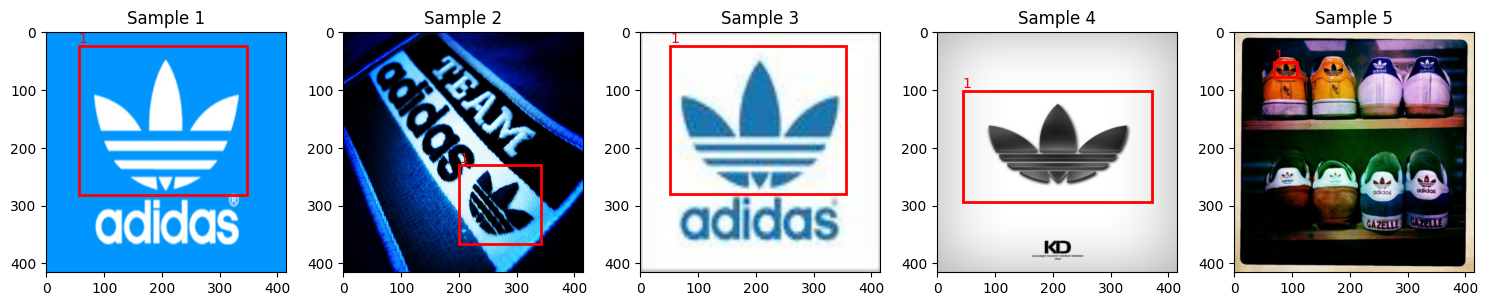

In [7]:
import matplotlib.pyplot as plt
import cv2
import os

def visualize_resized_samples(resized_images, adjusted_bboxes, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        if i >= len(resized_images):
            break
        
        image = resized_images[i]
        bbox = adjusted_bboxes[i]
        label = labels[i]
        
        # Convert image to RGB format (OpenCV loads images in BGR format)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Plot the image
        axes[i].imshow(image_rgb)
        axes[i].set_title(f"Sample {i + 1}")
        
        # Plot bounding box
        xmin, ymin, xmax, ymax = bbox
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             edgecolor='r', facecolor='none', linewidth=2)
        axes[i].add_patch(rect)
        axes[i].text(xmin, ymin - 5, label, color='r')

    plt.tight_layout()
    plt.show()

# Visualize 5 samples from the preprocessed dataset
visualize_resized_samples(resized_images, adjusted_bboxes, labels, num_samples=5)


In [8]:
data.head()

,Image,Class,Label,Xmin,Ymin,Xmax,Ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


``Normalize pixel values``

In [9]:
# Normalize pixel values
resized_images = resized_images.astype('float32') / 255.0

# Check the range of pixel values after normalization
print("Minimum Pixel Value After Normalization:", np.min(resized_images))
print("Maximum Pixel Value After Normalization:", np.max(resized_images))

Minimum Pixel Value After Normalization: 0.0
Maximum Pixel Value After Normalization: 1.0


``Split the data``

In [10]:
from sklearn.model_selection import train_test_split

# Assuming you have already preprocessed your data using the provided functions

# Split the data into training (80%) and temporary (20%) sets
train_data, temp_data, train_labels, temp_labels, train_bboxes, temp_bboxes = train_test_split(
    resized_images, labels, adjusted_bboxes, test_size=0.2, random_state=42)

# Split the temporary set into validation (50%) and test (50%) sets
val_data, test_data, val_labels, test_labels, val_bboxes, test_bboxes = train_test_split(
    temp_data, temp_labels, temp_bboxes, test_size=0.5, random_state=42)

# Check the sizes of the splits
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (3628, 416, 416, 3)
Validation data shape: (454, 416, 416, 3)
Test data shape: (454, 416, 416, 3)


In [11]:
print("Unique values in train_labels:", np.unique(train_labels))
print("Unique values in val_labels:", np.unique(val_labels))

Unique values in train_labels: [1 2 3 4 5 6]
Unique values in val_labels: [1 2 3 4 5 6]


In [12]:
# Subtract 1 from each label to shift the indices from 1-based to 0-based
train_labels -= 1
val_labels -= 1

In [13]:
print("Unique values in train_labels:", np.unique(train_labels))
print("Unique values in val_labels:", np.unique(val_labels))

Unique values in train_labels: [0 1 2 3 4 5]
Unique values in val_labels: [0 1 2 3 4 5]


In [14]:
import tensorflow as tf

# Assuming train_labels and val_labels are your class labels as integers
# Convert class labels to one-hot encoded vectors
num_classes = 6  # Number of classes in your dataset
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)

# Verify the shape of the one-hot encoded labels
print("Shape of train_labels_one_hot:", train_labels.shape)
print("Shape of val_labels_one_hot:", val_labels.shape)

Shape of train_labels_one_hot: (3628, 6)
Shape of val_labels_one_hot: (454, 6)


In [15]:
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# # One-hot encode the class labels
# encoder = OneHotEncoder()
# train_labels = encoder.fit_transform(train_labels.reshape(-1, 1))
# val_labels = encoder.transform(val_labels.reshape(-1, 1))
# test_labels = encoder.transform(test_labels.reshape(-1, 1))

In [16]:
# # Convert the sparse matrix to a dense array
# train_labels_array = train_labels.toarray()
# val_labels_array = val_labels.toarray()
# test_labels_array = test_labels.toarray()

# # Display the arrays
# print("Encoded Training Labels:")
# print(train_labels_array)
# print("\nEncoded Validation Labels:")
# print(val_labels_array)
# print("\nEncoded Test Labels:")
# print(test_labels_array)

``Backbone: VGG-16``

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG-16 model without including the top (fully connected) layers
vgg_backbone = VGG16(weights='imagenet', include_top=False, input_shape=(416, 416, 3))

# Freeze the convolutional layers of the VGG-16 backbone
for layer in vgg_backbone.layers:
    layer.trainable = False

# Print the summary of the VGG-16 backbone
# vgg_backbone.summary()


``Region proposal``

In [18]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Input

# Define the input tensor for the RPN
rpn_input = vgg_backbone.output  # Output of the VGG-16 backbone

# Add a 3x3 convolutional layer with 512 filters and 'same' padding
rpn_conv = Conv2D(512, (3, 3), padding='same', activation='relu', name='rpn_conv')(rpn_input)

# Add a 1x1 convolutional layer for predicting objectness scores
objectness_scores = Conv2D(2, (1, 1), activation='softmax', name='objectness_scores')(rpn_conv)

# Add a 1x1 convolutional layer for predicting bounding box deltas
bbox_deltas = Conv2D(4, (1, 1), activation='linear', name='bbox_deltas')(rpn_conv)

# Define the input and output tensors for the RPN
rpn_model = tf.keras.Model(inputs=vgg_backbone.input, outputs=[objectness_scores, bbox_deltas])

# Print the summary of the RPN model
# rpn_model.summary()


``Region of Interest pooling``

In [19]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, Concatenate
from tensorflow.keras.models import Model

# Define input tensor for ROI pooling
roi_input = rpn_model.output[0]  # Output of the RPN model

# Add a separate 2x2 MaxPooling2D layer for each output of the RPN model
pooling_layers = []
for output_tensor in rpn_model.output:
    pooling_layer = MaxPooling2D(pool_size=(2, 2))(output_tensor)
    pooling_layers.append(pooling_layer)

# Concatenate the pooled features along the channel axis
roi_pooling = Concatenate(axis=-1)(pooling_layers)

# Flatten the ROI pooled features
flattened_roi = Flatten()(roi_pooling)

# Add fully connected layers for classification and regression
fc1 = Dense(1024, activation='relu')(flattened_roi)
fc2 = Dense(1024, activation='relu')(fc1)

# Output layer for classification
num_classes = 6  # Example: 20 object classes + background
classification_output = Dense(num_classes, activation='softmax', name='classification')(fc2)

# Output layer for bounding box regression
regression_output = Dense(4, activation='linear', name='regression')(fc2)

# Define input and output tensors for the ROI pooling model
roi_model = Model(inputs=rpn_model.input, outputs=[classification_output, regression_output])

# Print the summary of the ROI pooling model
# roi_model.summary()

``Bounding Box Regression and Classification``

In [20]:
from tensorflow.keras.layers import Flatten, Dense

# Assuming rpn_model.output is a tuple containing multiple tensors
rpn_output_tensor = rpn_model.output[0]  # Choose the first tensor from the tuple

# Flatten the output of the RPN
rpn_output_flattened = Flatten()(rpn_output_tensor)

# Add fully connected layers for bounding box regression
bbox_regression_fc1 = Dense(512, activation='relu')(rpn_output_flattened)
bbox_regression_fc2 = Dense(512, activation='relu')(bbox_regression_fc1)
bbox_deltas_output = Dense(4, activation='linear', name='bbox_deltas')(bbox_regression_fc2)  # Output layer for bounding box regression

# Add fully connected layers for object classification
classification_fc1 = Dense(512, activation='relu')(rpn_output_flattened)
classification_fc2 = Dense(512, activation='relu')(classification_fc1)
num_classes = 6  # Example: 20 object classes + background
classification_output = Dense(num_classes, activation='softmax', name='classification')(classification_fc2)  # Output layer for classification

# Define input and output tensors for the model
final_model = tf.keras.Model(inputs=rpn_model.input, outputs=[classification_output, bbox_deltas_output])

# Print the summary of the final model
# final_model.summary()

``Loss function``

In [21]:
import tensorflow as tf

def rpn_classification_loss(y_true, y_pred):
    # y_true: true labels (1 for positive anchors, 0 for negative anchors, -1 for neutral anchors)
    # y_pred: predicted probabilities for objectness scores (softmax output)
    if tf.sparse.is_sparse(y_true):
        print("y_true is a SparseTensor")
    else:
        print("y_true is not a SparseTensor")
    
    # Filter out the neutral anchors (-1 labels)
    indices = tf.where(tf.not_equal(y_true, -1))
    y_true = tf.gather_nd(y_true, indices)
    y_pred = tf.gather_nd(y_pred, indices)
    
    # Compute binary cross-entropy loss
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rpn_regression_loss(y_true, y_pred):
    # y_true: true bounding box deltas
    # y_pred: predicted bounding box deltas
    
    # Filter out the neutral anchors (-1 labels)
    indices = tf.where(tf.not_equal(tf.reduce_sum(tf.abs(y_true), axis=1), 0))
    y_true = tf.gather_nd(y_true, indices)
    y_pred = tf.gather_nd(y_pred, indices)
    
    # Compute smooth L1 loss
    loss = tf.keras.losses.Huber()(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rcnn_classification_loss(y_true, y_pred):
    # y_true: true class labels (one-hot encoded)
    # y_pred: predicted class probabilities
    
    # Compute categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rcnn_regression_loss(y_true, y_pred):
    # y_true: true bounding box deltas
    # y_pred: predicted bounding box deltas
    
    # Compute smooth L1 loss
    loss = tf.keras.losses.Huber()(y_true, y_pred)
    
    return tf.reduce_mean(loss)

# Combine the losses for RPN and RCNN
def total_loss(y_true, y_pred):
    rpn_cls_true, rpn_reg_true, rcnn_cls_true, rcnn_reg_true = y_true
    rpn_cls_pred, rpn_reg_pred, rcnn_cls_pred, rcnn_reg_pred = y_pred
    
    rpn_cls_loss = rpn_classification_loss(rpn_cls_true, rpn_cls_pred)
    rpn_reg_loss = rpn_regression_loss(rpn_reg_true, rpn_reg_pred)
    rcnn_cls_loss = rcnn_classification_loss(rcnn_cls_true, rcnn_cls_pred)
    rcnn_reg_loss = rcnn_regression_loss(rcnn_reg_true, rcnn_reg_pred)
    
    total_loss = rpn_cls_loss + rpn_reg_loss + rcnn_cls_loss + rcnn_reg_loss
    
    return total_loss

In [22]:
# Compile the model with appropriate loss functions and metrics
final_model.compile(optimizer='adam',
                    loss={'classification': rcnn_classification_loss, 'bbox_deltas': rcnn_regression_loss},
                    loss_weights={'classification': 1.0, 'bbox_deltas': 1.0},
                    metrics={'classification': 'accuracy', 'bbox_deltas': 'mae'})

In [23]:
# Train the model
history = final_model.fit(train_data, [train_labels, train_bboxes],
                           batch_size=32,
                           epochs=5,
                           validation_data=(val_data, [val_labels, val_bboxes]))


Epoch 1/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 2120s 19s/step - bbox_deltas_mae: 133.0329 - classification_accuracy: 0.2505 - loss: 134.2850 - val_bbox_deltas_mae: 82.3530 - val_classification_accuracy: 0.3084 - val_loss: 83.5544
Epoch 2/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 2160s 19s/step - bbox_deltas_mae: 83.9827 - classification_accuracy: 0.2678 - loss: 85.1704 - val_bbox_deltas_mae: 82.1907 - val_classification_accuracy: 0.3084 - val_loss: 83.3838
Epoch 3/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 2212s 19s/step - bbox_deltas_mae: 84.0879 - classification_accuracy: 0.2695 - loss: 85.2819 - val_bbox_deltas_mae: 81.9311 - val_classification_accuracy: 0.3084 - val_loss: 83.1179
Epoch 4/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 2287s 20s/step - bbox_deltas_mae: 83.2135 - classification_accuracy: 0.2687 - loss: 84.4103 - val_bbox_deltas_mae: 82.1019 - val_classification_accuracy: 0.3084 - val_loss: 83.2953
Epoch 5/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 2317s 20s/step - bbox_deltas_mae: 84.2111 - classification_accuracy: 0.2715 - l

In [24]:
# Save the trained model
final_model.save("rcnn_model.h5")

In [26]:
final_model.save("rcnn_model.keras")

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("rcnn_model.keras")

# Now you can use the loaded model for prediction or any other tasks


-----------------------------

In [25]:
kk

NameError: name 'kk' is not defined

``Loss function``

I define a custom loss function that takes both true labels (y_true) and predictions (y_pred) as inputs. Inside custom_loss, I separate the true labels and predictions for classification and bounding box regression. I compute the classification loss using categorical crossentropy and the bounding box regression using smooth L1 loss. Finally, I combine the classification and bounding box regression losses to get the total loss. I also define the smooth_l1_loss function separaetly, which computes the smooth L1 loss element-wise and then calculates the mean loss across all elements. The final model is compiled using the custom loss function. Now, when you train the model, it will optimize the parameters based on this combined loss function. 

In [ ]:
def custom_loss(y_true, y_pred):
    # Separate the true labels and predictions for classification and bounding box regression
    true_classification, true_bbox_deltas = y_true
    pred_classification, pred_bbox_deltas = y_pred
    
    # Compute classification loss using categorical crossentropy
    classification_loss = tf.keras.losses.categorical_crossentropy(true_classification, pred_classification)
    
    # Compute bounding box regression loss using smooth L1 loss
    bbox_regression_loss = smooth_l1_loss(true_bbox_deltas, pred_bbox_deltas)
    
    # Print the computed losses
    print("Classification Loss:", classification_loss)
    print("Bounding Box Regression Loss:", bbox_regression_loss)
    
    # Combine classification and bounding box regression losses
    total_loss = classification_loss + bbox_regression_loss
    
    return total_loss, classification_loss, bbox_regression_loss

def smooth_l1_loss(y_true, y_pred, delta=1.0):
    # Compute smooth L1 loss element-wise
    abs_diff = tf.abs(y_true - y_pred)
    loss = tf.where(abs_diff < delta, 0.5 * tf.square(abs_diff), delta * (abs_diff - 0.5 * delta))
    
    # Compute mean loss across all elements
    return tf.reduce_mean(loss)

In [ ]:
import tensorflow as tf

# Define sample true labels and predictions as TensorFlow tensors
true_classification = tf.constant([[1, 0]])
pred_classification = tf.constant([[0.9, 0.1]])
true_bbox_deltas = tf.constant([[1.0, 2.0, 3.0, 4.0]])
pred_bbox_deltas = tf.constant([[0.9, 2.1, 3.1, 3.9]])

# Call the custom_loss function and print its output
loss, classification_loss, bbox_regression_loss = custom_loss(
    [true_classification, true_bbox_deltas],
    [pred_classification, pred_bbox_deltas]
)

print("Total Loss:", loss)
print("Classification Loss:", classification_loss)
print("Bounding Box Regression Loss:", bbox_regression_loss)

Classification Loss: tf.Tensor([0.10536055], shape=(1,), dtype=float32)
Bounding Box Regression Loss: tf.Tensor(0.0049999934, shape=(), dtype=float32)
Total Loss: tf.Tensor([0.11036054], shape=(1,), dtype=float32)
Classification Loss: tf.Tensor([0.10536055], shape=(1,), dtype=float32)
Bounding Box Regression Loss: tf.Tensor(0.0049999934, shape=(), dtype=float32)


In [ ]:
# Compile the final model with the custom loss function
final_model.compile(optimizer='adam', loss=custom_loss)


In [ ]:
d

``Train the model``

In [ ]:
# Fit the RCNN model
history = final_model.fit(
    x=train_data,
    y={"class_output": train_labels, "bbox_output": train_bboxes},
    validation_data=(val_data, {"class_output": val_labels, "bbox_output": val_bboxes}),
    epochs=10,
    batch_size=32
)

Epoch 1/10


ValueError: No loss to compute. Provide a `loss` argument in `compile()`.

In [ ]:
# Evaluate the model on the test set
test_loss, test_class_loss, test_bbox_loss = final_model.evaluate(test_data, {"class_output": test_labels, "bbox_output": test_bboxes})

print("Test loss:", test_loss)
print("Test classification loss:", test_class_loss)
print("Test bounding box regression loss:", test_bbox_loss)

In [ ]:
# Optionally, you can visualize the training progress using the history object
# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

-------